# TCLab Mathematical Model

We will use the TCLab as a motivating example for this workshop.

The code below sets default font sizes.

In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

## Temperature control lab

The [temperature control lab](http://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) is an Arduino-based hands-on experiment for teaching dynamic modeling and process control developed by Prof. John Hedengren. At Notre Dame, we restructured our core [undergraduate process control class](https://ndcbe.github.io/controls/Readme.html) around six hands-on laboratory assignments with the TCLab.

The TCLab board contains two heater plus temperature sensor assemblies. Using Python (or MATLAB), students can independently maninputate the electrical power to the heaters and measure the temperatures.

![TC Lab hardware](https://ndcbe.github.io/controls/_images/TCLab_labelled.jpg)

## System identification data

Using the TCLab, we performed two system identification tests: step test and sine wave test.

### Step test

We will start by loading the data using `pandas`.

In [2]:
import sys

on_colab = "google.colab" in sys.modules
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_step_test.csv"
else:
    file = '../data/tclab_step_test.csv'

import pandas as pd

df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.84,22.84,50.0,0.0
1,1.00,22.84,22.84,50.0,0.0
2,2.01,23.16,22.84,50.0,0.0
3,3.02,22.84,22.84,50.0,0.0
4,4.01,22.84,22.84,50.0,0.0


Let's start by plotting the heater data.

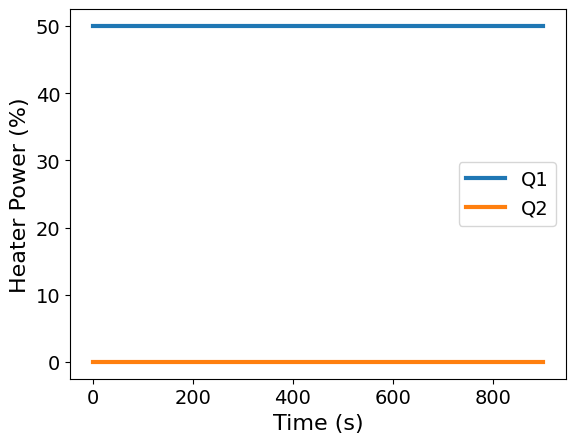

In [3]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In this step test, heater 1 was set to 50% power and heater 2 was off. Let's see the resulting temperature profiles.

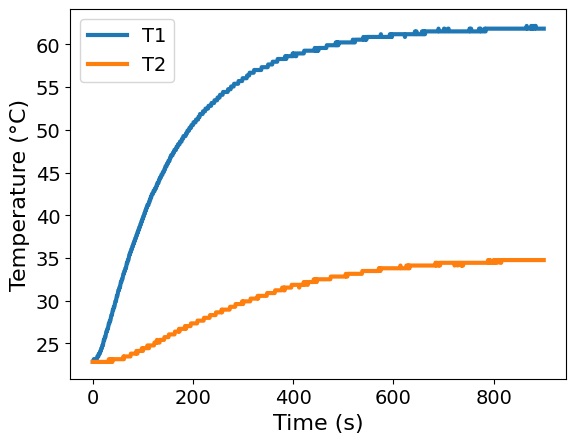

In [4]:
import matplotlib.pyplot as plt

ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

As expected, temperature 1 rises as expected for a (near) linear system. The experimentation noise is noticeable once the device approaches steady-state after 600 seconds. As expected, temperature 2 gradually rises in response to heater assembly 1 heating up. On the device, the two heater assembles are separated by ~1 cm.

### Sine test

In [5]:
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test_5min_period.csv"
else:
    file = '../data/tclab_sine_test_5min_period.csv'

df2 = pd.read_csv(file)
df2.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.2,22.2,50,0
1,1.01,22.2,22.2,51,0
2,2.01,22.2,22.2,52,0
3,3.00,22.2,22.2,53,0
4,4.01,22.2,22.2,54,0


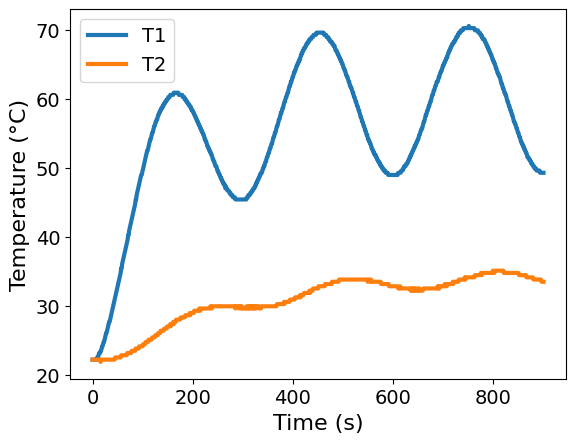

In [6]:
ax = df2.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

## Two-state mathematical model

Using these data, we want to develop a science-based mathematical model for the TCLab. For simplicity, we will develop a mathemical single heater and temperature sensor assembly. However, this workshop example also supports modeling both assemblies.

![TCLab schematic](../images/tclab_schematic2.jpg)

We will define two **states**:
* $T_{H,1}$ is the temperature of the heater/fin assembly (°C)
* $T_{S,1}$ is the temperature of the sensor (°C)

Assumptions:
* The two bodies are uniform temperature, i.e., we are neglecting any temperature gradients in the fin.
* The sensor exchanges heat only with the heater, and heat transfer to the surroundings is dominated by the heat sink attached to the heater.]
* Heat capacities $C_p$ are constant.
* Radiative heat transfer is negligible.

We define the **manipulated variable**:
* $u_1$ is the power sent to the heater (% of max)

This motivates the following model:

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}
$$

The model has the following **unknown parameters**:
* $C^H_p$ is the heat capacity of the heater/fin assembly (J / °C)
* $C^S_p$ is the heat capacity of the sensor (J / °C)
* $U_a$ is the heat transfer coefficient from the heater/fin to ambient (W / °C)
* $U_b$ is the heat transfer coefficient from the heater/fin to the sensor (W / °C)

And the following **known parameters**:
* $\alpha P_1$ are constants for the TCLab (W / %)
* $T_{amb}$ is the ambient temperature (°C)


## State space model

Although not essential for this tutorial, we can write this model a a state space linear system.

The initial steady state is $T_{amb}$. So let's write the dependent variables as excursions from the ambient temperature.

$$
\begin{align}
C^H_p\frac{d(T_{H,1} - T_{amb})}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b((T_{S,1} - T_{amb}) - (T_{H,1} - T_{amb})) + \alpha P_1u_1\\
C^S_p\frac{d(T_{S,1} - T_{amb})}{dt} & = U_b((T_{H,1} - T_{amb}) - (T_{S,1} - T_{amb}))
\end{align}
$$

Then divide by the heat capacities.

$$
\begin{align}
\frac{d(T_{H,1} - T_{amb})}{dt} & = -\frac{U_a+U_b}{C^H_p}(T_{H,1} - T_{amb}) + \frac{U_b}{C^H_p}(T_{S,1} - T_{amb}) + \frac{\alpha P_1}{C^H_p}u_1 \\
\frac{d(T_{S,1} - T_{amb})}{dt} & = \frac{U_b}{C^S_p}((T_{H,1} - T_{amb}) - (T_{S,1} - T_{amb})) 
\end{align}
$$

The two-state model can be rewritten using vectors to collect the states, inputs, measurable outputs, and arrays to collect the coefficients of the differential equations. 

$$
\begin{align}
\frac{d}{dt}\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_\mathbf{x} & = 
\underbrace{\begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p}\end{bmatrix}}_\mathbf{A} 
\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_\mathbf{x} + 
\underbrace{\begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix}}_\mathbf{B} 
\underbrace{\begin{bmatrix} u_1 \end{bmatrix}}_\mathbf{u} \\
\\
\underbrace{\begin{bmatrix} T_{S,1} - T_{amb} \end{bmatrix}}_\mathbf{y} & = 
\underbrace{\begin{bmatrix}0 & 1 \end{bmatrix}}_\mathbf{C} 
\underbrace{\begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix}}_\mathbf{x}
\end{align}
$$

In other words, we can write the temperature control lab model as a **state-space model**

$$
\begin{align}
\frac{d\mathbf{x}}{dt} & = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} \\
\mathbf{y} & = \mathbf{C} \mathbf{x}
\end{align}
$$

where the state space variables are the deviations of temperature from the ambient $T_{amb}$:

$$
\begin{align}
\mathbf{u} & = \begin{bmatrix} u_1 \end{bmatrix} && \text{inputs} \\
\\
\mathbf{x} & = \begin{bmatrix} T_{H,1} - T_{amb} \\ T_{S,1} - T_{amb} \end{bmatrix} && \text{states} \\
\\
\mathbf{y} & = \begin{bmatrix} T_{S,1} - T_{amb} \end{bmatrix} && \text{measurements} \\
\end{align}
$$

and the parameters are embedded in the matrices:

$$
\begin{align}
\mathbf{A} = \begin{bmatrix} -\frac{U_a+U_b}{C^H_p} & \frac{U_b}{C^H_p} \\ \frac{U_b}{C^S_p} & - \frac{U_b}{C^S_p}\end{bmatrix}
\quad
\mathbf{B} = \begin{bmatrix} \frac{\alpha P_1}{C^H_p} \\ 0 \end{bmatrix} 
\quad
\mathbf{C} = \begin{bmatrix}0 & 1 \end{bmatrix} \\
\end{align}
$$